In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from olympus.evaluators import Evaluator
from olympus.campaigns import Campaign, ParameterSpace
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.planners import Planner
from olympus.utils.data_transformer import simpl_to_cube, cube_to_simpl
from olympus.models import BayesNeuralNet

In [ ]:
dataset = Dataset(kind='thin_film')
print(dataset.data.shape)
dataset.data.head()


In [ ]:
print(dataset.param_space)

In [ ]:
print(dataset.aux_param_space)

In [ ]:
emulator = Emulator(dataset='thin_film', model='BayesNeuralNet')

In [ ]:
planner = Planner(kind='RandomSearch', goal='minimize')
planner.set_param_space(dataset.aux_param_space)


campaign = Campaign()
campaign.set_param_space(emulator.param_space)
campaign.set_value_space(emulator.value_space)

In [ ]:
print(campaign.param_space)

In [ ]:
budget = 5

for i in range(budget):
    
    print('ITERATION : ', i)
    
    campaign.observations_to_cube()
    
    params = planner.recommend(campaign.observations)
    # transform from cube to simplex
    params = params.to_array()
    simpl_params = cube_to_simpl([params])
    
    measurement = emulator.run(simpl_params[0])
    print(f'PARAMS : {simpl_params}\tMEASUREMENT : { measurement[0][0]}')
    
    
    print('cube observations :', campaign.observations.get_params())

    campaign.observations_to_simpl()
    
    
    
    print('simpl observations :', campaign.observations.get_params())
    
    
    campaign.add_observation(simpl_params[0], measurement[0][0])
    

    
    print('\n')

## Same experiment using the higher-level evaluator

In [ ]:
dataset = Dataset(kind='thin_film')
dataset.constraints

In [ ]:
emulator = Emulator(dataset='thin_film', model='BayesNeuralNet')

planner = Planner(kind='RandomSearch', goal='minimize')
#planner.set_param_space(dataset.aux_param_space)


campaign = Campaign()
campaign.set_param_space(emulator.param_space)
campaign.set_value_space(emulator.value_space)

In [ ]:
#emulator.__dict__['dataset'].constraints['parameters'] = 'simplex'

In [ ]:
#emulator.__dict__['dataset'].constraints

In [ ]:
evaluator = Evaluator(planner=planner, emulator=emulator, campaign=campaign)

In [ ]:
evaluator.optimize(num_iter=5)

## Test OER datasets (discrete optimization with simplex constriant)

In [ ]:
oer_datasets = ['oer_plate_3496', 'oer_plate_3851', 'oer_plate_3860', 'oer_plate_4098' ]

In [ ]:
for oer_dataset in oer_datasets:
    dataset = Dataset(kind=oer_dataset)
    print(dataset.shape)
    print(dataset.param_types)
    dataset.data.head()

In [ ]:
dataset = Dataset(kind='oer_plate_4098')
print(dataset.shape)
print(dataset.param_types)
dataset.data.head()

In [ ]:
planner = Planner(kind='RandomSearch', goal='minimize')
planner.set_param_space(dataset.aux_param_space)

campaign = Campaign()
campaign.set_param_space(dataset.param_space)
campaign.set_value_space(dataset.value_space)

In [ ]:
evaluator = Evaluator(planner=planner, emulator=dataset, campaign=campaign)

In [ ]:
evaluator.optimize(num_iter=5)

In [ ]:

em = pickle.load(open('../src/olympus/emulators/emulator_benzylation_BayesNeuralNet/emulator.pickle', 'rb'))

In [ ]:
em.__dict__

In [ ]:
print(em.feature_transformer.transformations)
print(em.target_transformer.transformations)

In [21]:

important_hyperparams = ['batch_size', 
                         'es_patience', 'hidden_act', 'hidden_depth', 'hidden_nodes',
                         'kind', 'learning_rate', 'max_epochs', 'out_act', 'pred_int', 
                         'reg', 'scope']

In [22]:
# datasets_to_retrain = ['agnp', 'alkox', 'autoam', 'benzylation', 'colors_bob', 
#                      'colors_n9', 'crossed_barrel', 'hplc', 'p3ht', 'photo_pce10', 
#                      'photo_wf3', 'snar', 'suzuki_i', 'suzuki_ii', 'suzuki_iii', 'suzuki_iv',
#                     ] # thin film
datasets_to_retrain = ['suzuki', 'fullerenes']

In [23]:
# old_emulator = Emulator(dataset='agnp', model='BayesNeuralNet')
# feature_transform = old_emulator.feature_transformer.transformations[0]
# target_transform  = old_emulator.target_transformer.transformations[0]
# hyperparams = {param:old_emulator.model.get(param) for param in important_hyperparams}

In [24]:
all_hyperparams = {}

for name in datasets_to_retrain:
    old_emulator = Emulator(dataset=name, model='BayesNeuralNet')
    feature_transform = old_emulator.feature_transformer.transformations[0]
    target_transform  = old_emulator.target_transformer.transformations[0]
    hyperparams = {param:old_emulator.model.get(param) for param in important_hyperparams}
    
    all_hyperparams[f'{name}_BayesNeuralNet'] = {
        'feature_transform': feature_transform, 
        'target_transform': target_transform,
        'hyperparams': hyperparams,
    }

[INFO] Loading emulator using a BayesNeuralNet model for the dataset suzuki...
[INFO] Loading emulator using a BayesNeuralNet model for the dataset fullerenes...


In [25]:
pickle.dump(all_hyperparams, open('all_hyperparams.pkl', 'wb'))

In [26]:
# retrain all the emulator with the same hyperparameters
all_hyperparams = pickle.load(open('all_hyperparams.pkl', 'rb'))

for name in datasets_to_retrain:
    
    feature_transform = all_hyperparams[f'{name}_BayesNeuralNet']['feature_transform']
    target_transform = all_hyperparams[f'{name}_BayesNeuralNet']['target_transform']
    hyperparams = all_hyperparams[f'{name}_BayesNeuralNet']['hyperparams']
    
    hyperparams.pop('kind')
    
    
    model  = BayesNeuralNet(**hyperparams)
    emulator = Emulator(
            dataset=name, model=model, feature_transform=feature_transform, target_transform=target_transform,
        )
    scores = emulator.train(retrain=True)
    all_hyperparams[f'{name}_BayesNeuralNet']['scores'] = scores
    emulator.save(f'{name}_BayesNeuralNet', include_cv=False)


[INFO] >>> Training model on 80% of the dataset, testing on 20%...
[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.302          0.718         -0.873          0.697 *
[INFO]             100          0.085          0.453          0.051          0.496 *
[INFO]             200          0.840          0.189          0.674          0.291 *
[INFO]             300          0.853          0.182          0.742          0.259 *
[INFO]             400          0.821          0.200          0.742          0.259
[INFO]             500          0.867          0.172          0.745          0.257 *
[INFO]             600          0.879          0.165          0.764          0.248 *
[INFO]             700          0.870          0.170          0.782          0.238 *
[INFO]

[INFO]            8300          0.926          0.129          0.931          0.134
[INFO]            8400          0.942          0.114          0.936          0.129
[INFO]            8500          0.933          0.122          0.944          0.121 *
[INFO]            8600          0.939          0.117          0.945          0.119 *
[INFO]            8700          0.935          0.121          0.937          0.128
[INFO]            8800          0.927          0.128          0.934          0.131
[INFO]            8900          0.934          0.121          0.939          0.126
[INFO]            9000          0.924          0.131          0.921          0.143
[INFO]            9100          0.941          0.115          0.939          0.126
[INFO]            9200          0.945          0.111          0.938          0.127
[INFO]            9300          0.933          0.123          0.925          0.139
[INFO]            9400          0.944          0.112          0.937          0.128


[INFO]           17300          0.979          0.068          0.932          0.132
[INFO]           17400          0.977          0.073          0.927          0.138
[INFO]           17500          0.966          0.087          0.917          0.147
[INFO]           17600          0.980          0.067          0.918          0.146
[INFO]           17700          0.974          0.076          0.919          0.145
[INFO]           17800          0.980          0.067          0.931          0.134
[INFO]           17900          0.974          0.076          0.932          0.133
[INFO]           18000          0.976          0.073          0.935          0.130
[INFO]           18100          0.966          0.087          0.915          0.148
[INFO]           18200          0.971          0.080          0.934          0.131
[INFO]           18300          0.969          0.083          0.930          0.135
[INFO]           18400          0.976          0.074          0.924          0.141
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0        -33.306          1.013        -29.385          1.018 *
[INFO]             100          0.625          0.106          0.685          0.104 *
[INFO]             200          0.815          0.074          0.875          0.065 *
[INFO]             300          0.849          0.067          0.918          0.053 *
[INFO]             400          0.901          0.055          0.922          0.051 *
[INFO]             500          0.938          0.043          0.944          0.044 *
[INFO]             600          0.952          0.038          0.932          0.048
[INFO]             700          0.961          0.034          0.961          0.037 *
[INFO]             800          0.966          0.032          0.959      

[INFO]            8500          0.999          0.006          0.993          0.015
[INFO]            8600          0.999          0.006          0.992          0.017
[INFO]            8700          0.999          0.006          0.993          0.015
[INFO]            8800          0.999          0.005          0.993          0.016
[INFO]            8900          0.999          0.006          0.993          0.015
[INFO]            9000          0.999          0.005          0.992          0.016
[INFO]            9100          0.999          0.005          0.992          0.016
[INFO]            9200          0.998          0.007          0.993          0.015
[INFO]            9300          0.999          0.006          0.991          0.017
[INFO]            9400          0.999          0.005          0.993          0.016
[INFO]            9500          0.999          0.006          0.993          0.015
[INFO]            9600          0.999          0.006          0.992          0.017
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overpotential', ylabel='Density'>

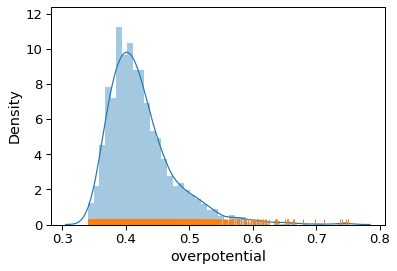

In [19]:
dset = Dataset(kind='oer_plate_3496')
sns.distplot(dset.data['overpotential'])
sns.rugplot(dset.data['overpotential'])

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overpotential', ylabel='Density'>

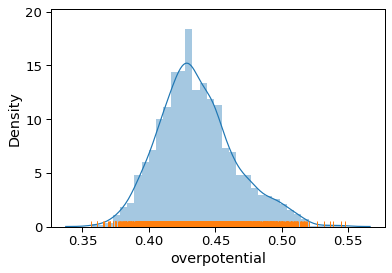

In [18]:
dset = Dataset(kind='oer_plate_3851')
sns.distplot(dset.data['overpotential'])
sns.rugplot(dset.data['overpotential'])

0.372861


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overpotential', ylabel='Density'>

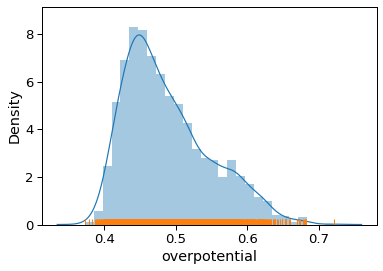

In [17]:
dset = Dataset(kind='oer_plate_3860')
print(np.amin(dset.data['overpotential']))
sns.distplot(dset.data['overpotential'])
sns.rugplot(dset.data['overpotential'])

0.3945909999999999


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overpotential', ylabel='Density'>

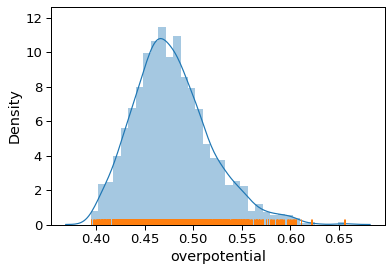

In [16]:
dset = Dataset(kind='oer_plate_4098')
print(np.amin(dset.data['overpotential']))
sns.distplot(dset.data['overpotential'])
sns.rugplot(dset.data['overpotential'])